In [171]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import qsturng


budget_level         High  Low
genre                         
Action                433    7
Adventure             487    3
Black Comedy           46    4
Comedy                593   59
Concert/Performance    10    1
Documentary            37   62
Drama                 908  141
Horror                219   36
Multiple Genres         0    1
Musical                42    2
Romantic Comedy       161   16
Thriller/Suspense     379   35
Western                24    1


C:\Users\User\AppData\Local\Temp\ipykernel_174796\3031986476.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['budget_level'] = filtered_df['production_budget'].apply(budget_category)
C:\Users\User\AppData\Local\Temp\ipykernel_174796\3031986476.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['total_box_office'] = filtered_df['domestic_box_office'] + filtered_df['international_box_office']
C:\Users\User\AppData\Local\Temp\ipykernel_174796\3031986476.py:22: SettingWithCopyWarn

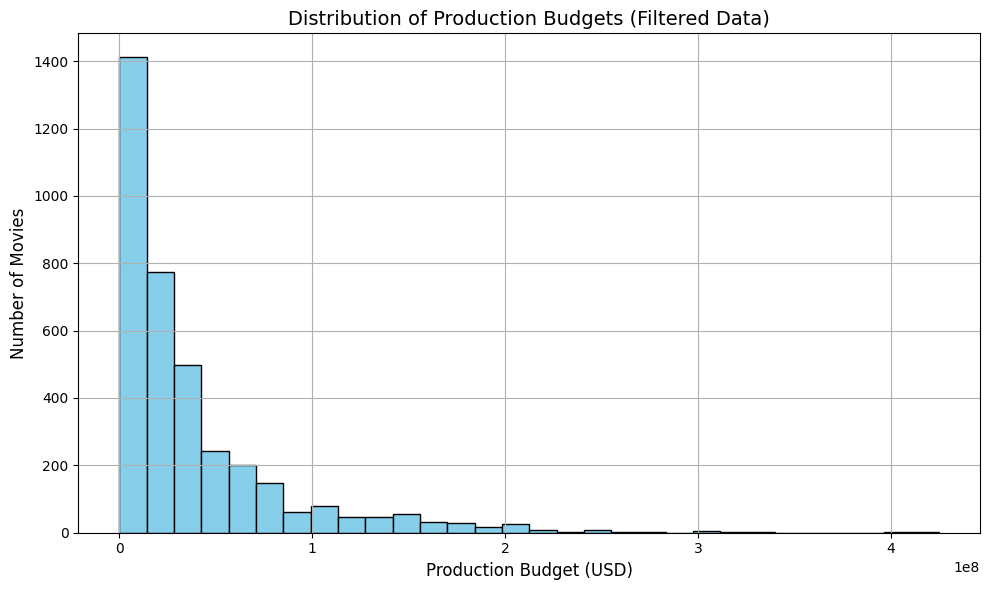

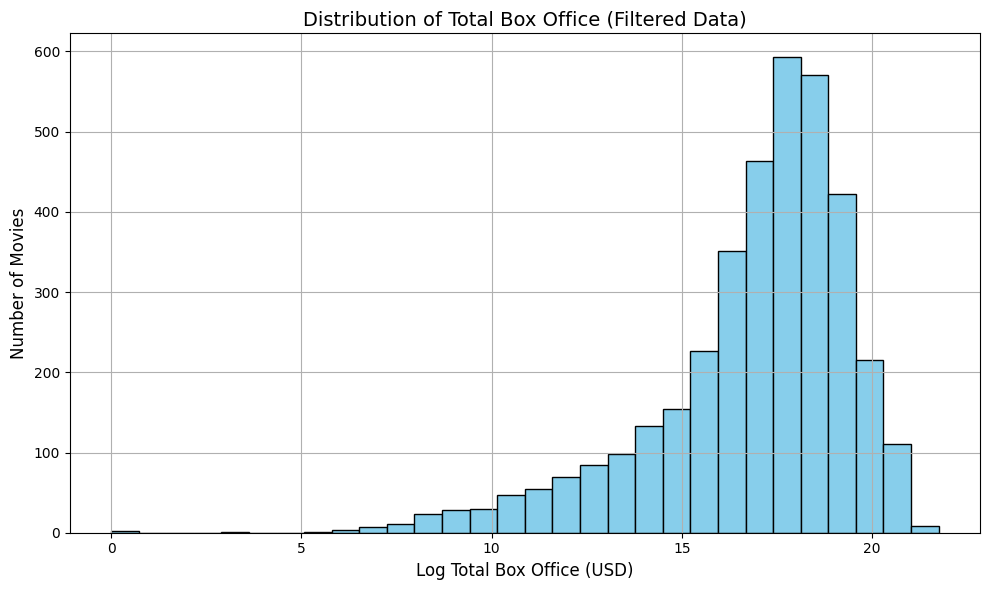

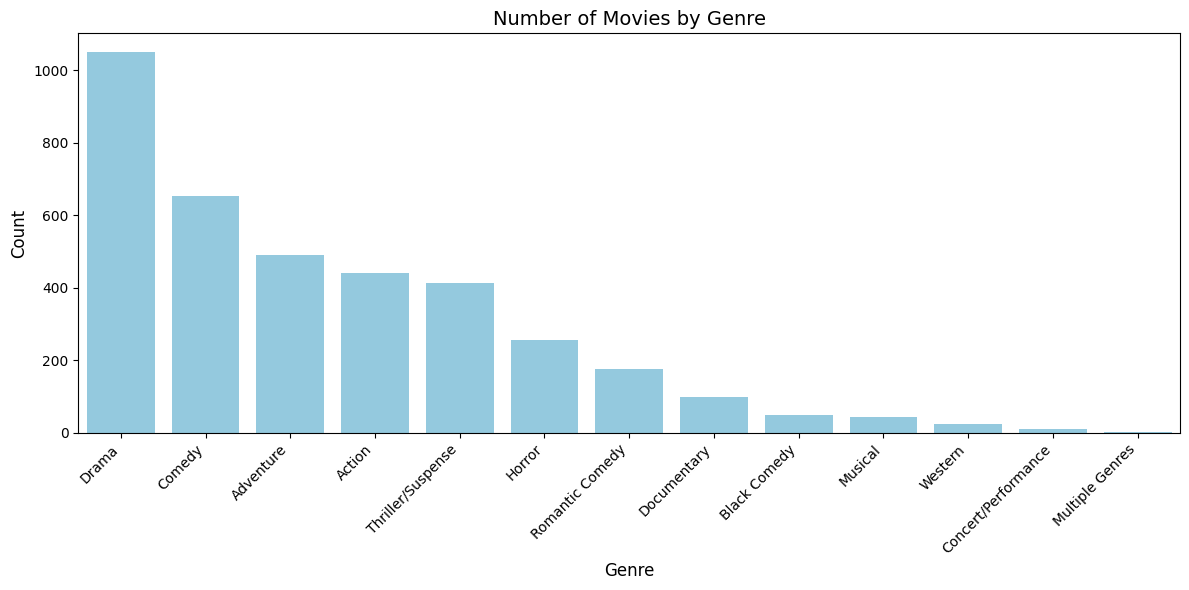

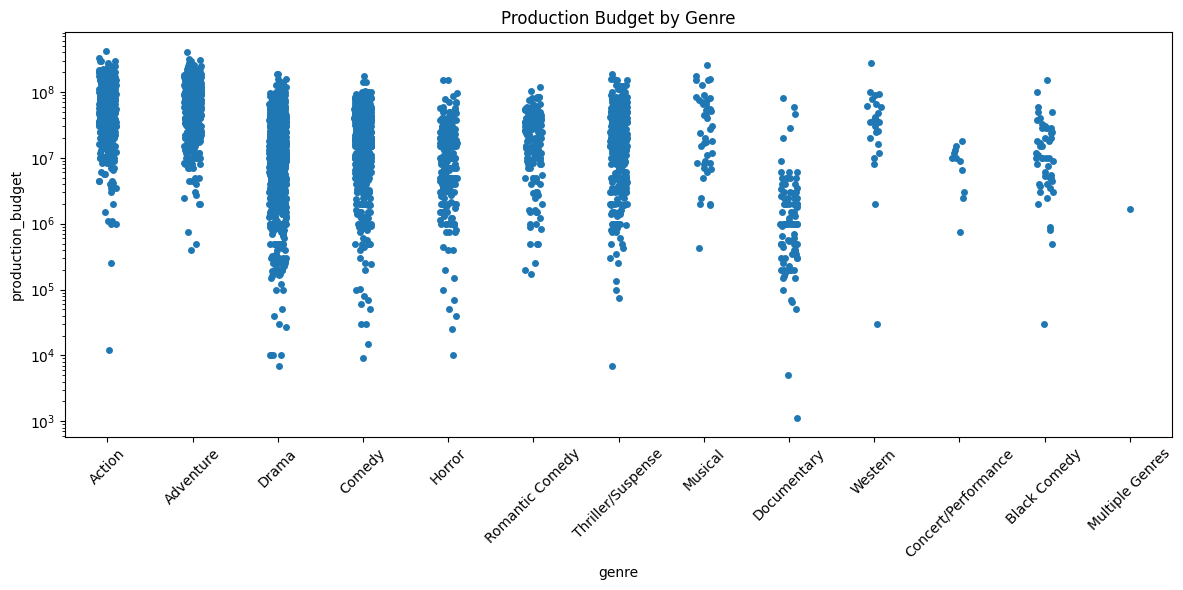

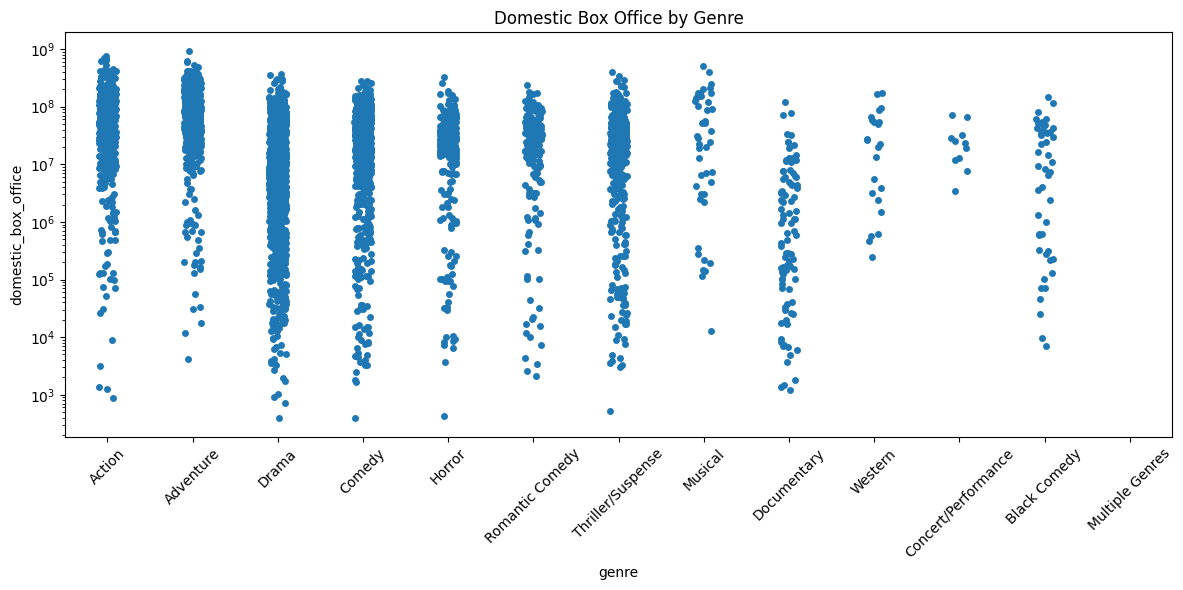

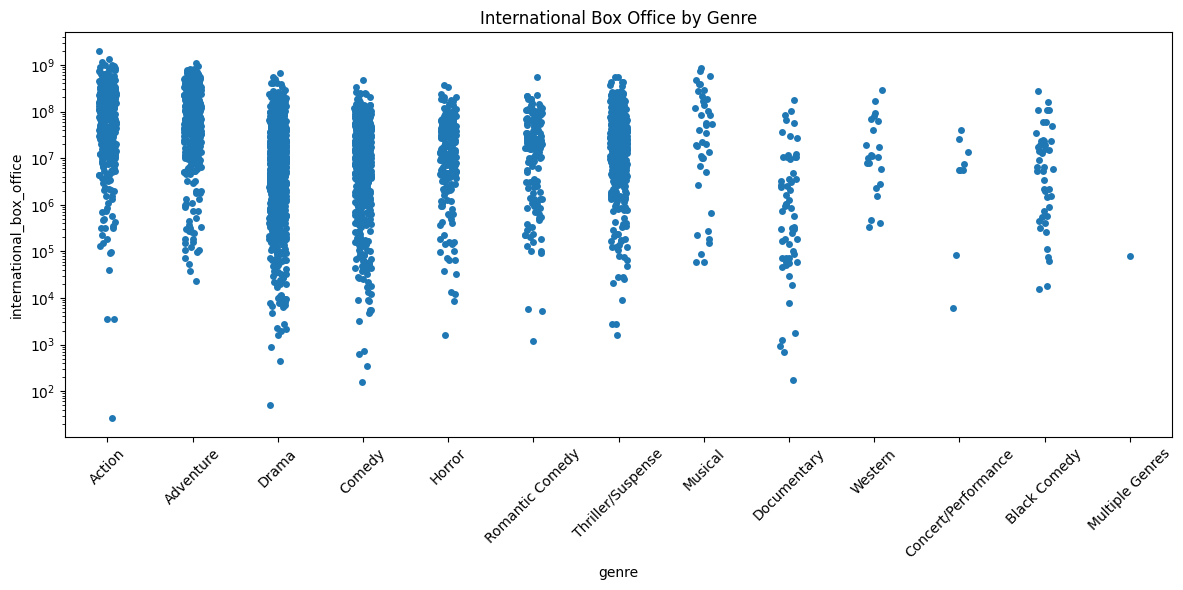

In [ ]:
# Load data
df = pd.read_csv('movie_summary.csv')

# Filter by production year and budget
filtered_df = df[
    (df['genre'] != "Reality") &
    (df['production_budget'] < 5000000) &
    (df['production_budget'] > 10000) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
]

def budget_category(budget):
    if budget < 2_000_000:
        return 'Low'
    else:
        return 'High'

filtered_df['budget_level'] = filtered_df['production_budget'].apply(budget_category)
filtered_df['total_box_office'] = filtered_df['domestic_box_office'] + filtered_df['international_box_office']
filtered_df['log_total_box_office'] = np.log1p(filtered_df['total_box_office'])
filtered_df['sqrt_total_box_office'] = np.power(filtered_df['total_box_office'], 1/2)

# Group by genre and budget_level, count number of samples in each block
group_counts = filtered_df.groupby(['genre', 'budget_level']).size().unstack(fill_value=0)

# Display the table
print(group_counts)

# Draw the histogram for budget
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['production_budget'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Production Budgets (Filtered Data)', fontsize=14)
plt.xlabel('Production Budget (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Draw the histogram for revenue
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['log_total_box_office'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Box Office (Filtered Data)', fontsize=14)
plt.xlabel('Log Total Box Office (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Draw the bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='genre', order=filtered_df['genre'].value_counts().index, color='skyblue')

plt.title('Number of Movies by Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Strip plot (with jitter to separate overlapping points)
plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='production_budget', jitter=True)
plt.yscale('log')
plt.title("Production Budget by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("budget_strip_plot")
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='domestic_box_office', jitter=True)
plt.yscale('log')
plt.title("Domestic Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='genre', y='international_box_office', jitter=True)
plt.yscale('log')
plt.title("International Box Office by Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

$$
\begin{aligned}
H_0: &\text{The box office of the movies of different genres are eqivalent.} \\
H_1: &\text{The box office of the movies of at least one genre is different from others.}
\end{aligned}
$$

In [173]:
# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['domestic_box_office']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['domestic_box_office'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.7068 | p = 0.0000
Genre: Adventure            | W = 0.8068 | p = 0.0000
Genre: Black Comedy         | W = 0.7387 | p = 0.0000
Genre: Comedy               | W = 0.7991 | p = 0.0000
Genre: Concert/Performance  | W = 0.8479 | p = 0.0401
Genre: Documentary          | W = 0.4102 | p = 0.0000
Genre: Drama                | W = 0.5986 | p = 0.0000
Genre: Horror               | W = 0.7363 | p = 0.0000
Genre: Musical              | W = 0.7320 | p = 0.0000
Genre: Romantic Comedy      | W = 0.8225 | p = 0.0000
Genre: Thriller/Suspense    | W = 0.6661 | p = 0.0000
Genre: Western              | W = 0.7651 | p = 0.0001

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = nan | p = nan



c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\scipy\stats\_morestats.py:2900: RuntimeWarning: invalid value encountered in log
  numer = ((Ntot - k) * xp.log(spsq)


In [174]:
from scipy.stats import kruskal

# Ensure filtered_df['genre'] is clean and non-null
groups = [group['domestic_box_office'].values for name, group in filtered_df.groupby('genre') if len(group) >= 5]

# Run test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

Kruskal-Wallis H = 574.058, p = 0.0000


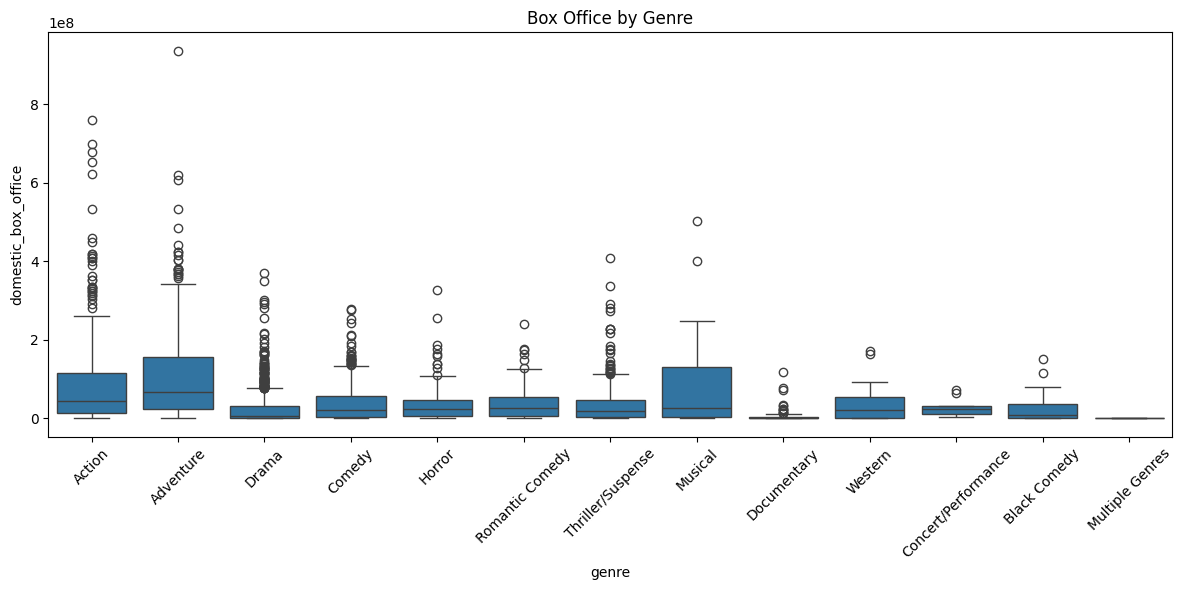

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='genre', y='domestic_box_office')
plt.xticks(rotation=45)
plt.title("Box Office by Genre")
plt.tight_layout()
plt.show()

In [176]:
# Ensure filtered_df['genre'] is clean and non-null
groups = [group['international_box_office'].values for name, group in filtered_df.groupby('genre') if len(group) >= 5]

# Run test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

Kruskal-Wallis H = 806.702, p = 0.0000


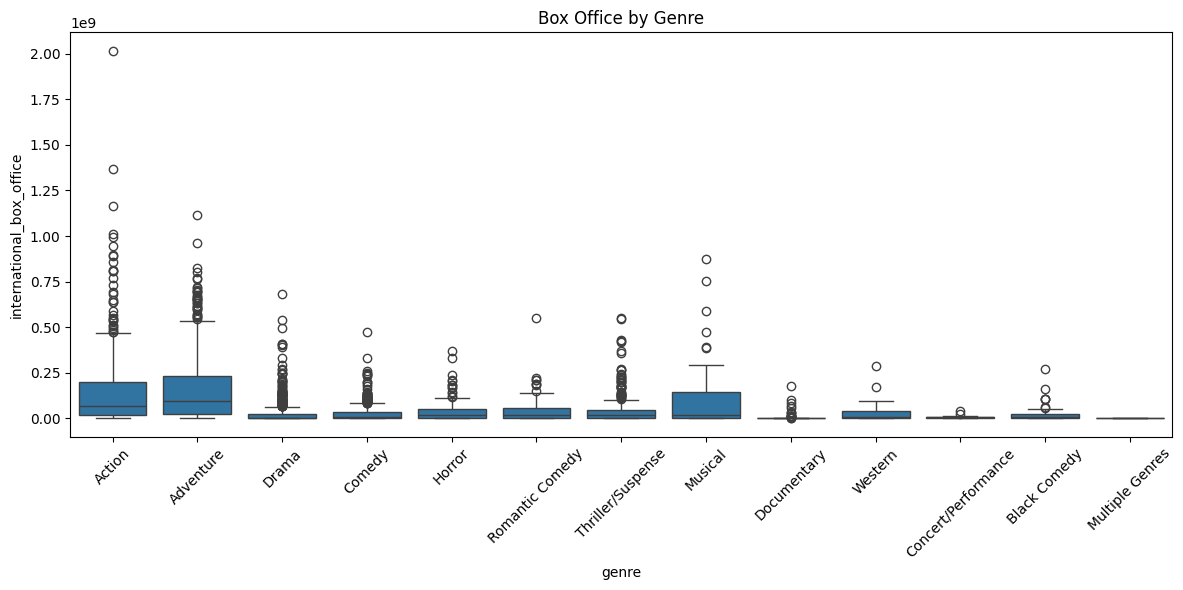

In [177]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='genre', y='international_box_office')
plt.xticks(rotation=45)
plt.title("Box Office by Genre")
plt.tight_layout()
plt.show()